c:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


AvgEtchRate LOOCV: R2=0.9030 RMSE=16.3039
ThicknessRange LOOCV: R2=0.3834 RMSE=3.4529

Proposed recipes (3):
 Etch_Avgcf4Flow  Etch_AvgO2Flow  Etch_Avg_Rf2_Pow  Etch_Avg_Rf1_Pow  Etch_AvgPres  Pred_AvgEtchRate  Unc_AvgEtchRate  Pred_ThicknessRange  Unc_ThicknessRange
            10.6            12.8             449.0              93.0           5.4         97.402354         9.010798             4.217664            2.885959
            14.2            15.7             639.0               5.0          97.9         79.827226        32.826695             4.562120            5.449594
            85.1            10.6             665.0              58.0          96.9         82.047193        26.207516             5.446814            5.294081


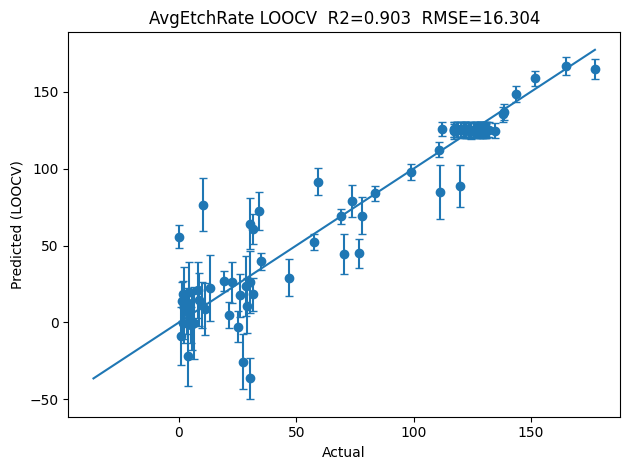

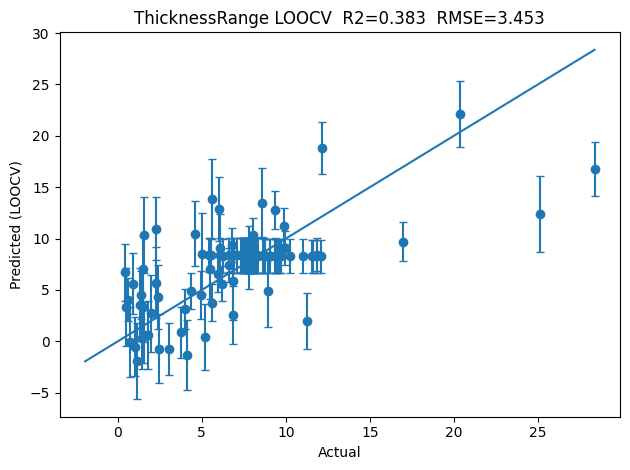

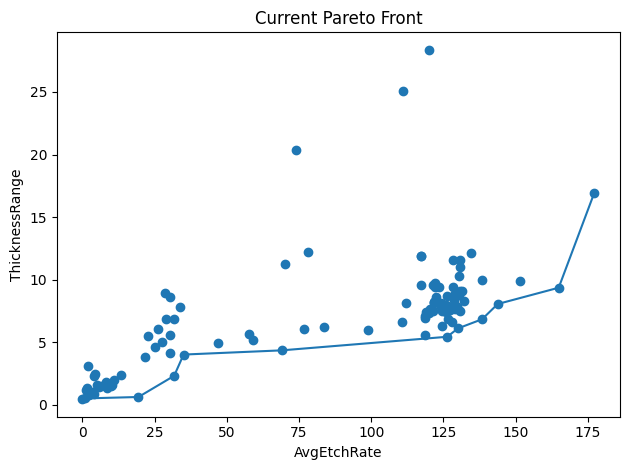

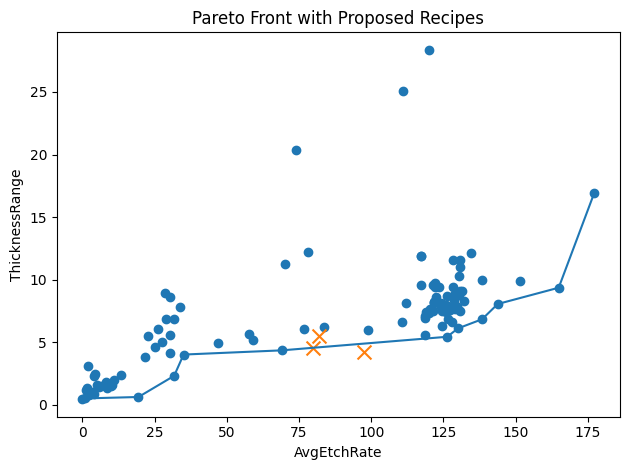

In [2]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

csv_path = "full_dataset.csv"

df = pd.read_csv(csv_path)
needed = [
    "Etch_AvgO2Flow","Etch_Avg_Rf1_Pow","Etch_Avg_Rf2_Pow",
    "Etch_AvgPres","Etch_Avgcf4Flow","AvgEtchRate","RangeEtchRate"
]
df = df.dropna(subset=needed).copy()
df["ThicknessRange"] = df["RangeEtchRate"] * 5.0

X_cols = ["Etch_AvgO2Flow","Etch_Avg_Rf1_Pow","Etch_Avg_Rf2_Pow","Etch_AvgPres","Etch_Avgcf4Flow"]
y1_col = "AvgEtchRate"
y2_col = "ThicknessRange"

X = df[X_cols].to_numpy(dtype=float)
y1 = df[y1_col].to_numpy(dtype=float)
y2 = df[y2_col].to_numpy(dtype=float)

def fit_gpr(X, y):
    xsc = StandardScaler()
    ysc = StandardScaler()
    Xs = xsc.fit_transform(X)
    ys = ysc.fit_transform(y.reshape(-1,1)).ravel()
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=False)
    gpr.fit(Xs, ys)
    return gpr, xsc, ysc

def loocv_metrics_and_plot(X, y, title):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    y_std = []
    for train_index, test_index in loo.split(X):
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        g, xs, ys = fit_gpr(Xtr, ytr)
        mu_s, std_s = g.predict(xs.transform(Xte), return_std=True)
        mu = ys.inverse_transform(mu_s.reshape(-1,1)).ravel()
        std = std_s * ys.scale_[0]
        y_true.append(yte[0])
        y_pred.append(mu[0])
        y_std.append(std[0])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_std = np.array(y_std)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.errorbar(y_true, y_pred, yerr=y_std, fmt='none', capsize=3)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted (LOOCV)")
    plt.title(f"{title}  R2={r2:.3f}  RMSE={rmse:.3f}")
    plt.tight_layout()
    return r2, rmse, y_true, y_pred, y_std

r2_1, rmse_1, _, _, _ = loocv_metrics_and_plot(X, y1, "AvgEtchRate LOOCV")
r2_2, rmse_2, _, _, _ = loocv_metrics_and_plot(X, y2, "ThicknessRange LOOCV")

gpr1, xsc1, ysc1 = fit_gpr(X, y1)
gpr2, xsc2, ysc2 = fit_gpr(X, y2)

def pareto_front_xy(xvals, yvals):
    order = np.argsort(-xvals)
    Xs = xvals[order]
    Ys = yvals[order]
    keep = []
    best_y = np.inf
    for i in range(len(Xs)):
        if Ys[i] <= best_y + 1e-12:
            keep.append(order[i])
            best_y = min(best_y, Ys[i])
    keep = np.array(keep, dtype=int)
    return keep

obs_x = y1
obs_y = y2
pf_idx = pareto_front_xy(obs_x, obs_y)
pf_x = obs_x[pf_idx]
pf_y = obs_y[pf_idx]

plt.figure()
plt.scatter(obs_x, obs_y)
plt.plot(pf_x, pf_y)
plt.xlabel("AvgEtchRate")
plt.ylabel("ThicknessRange")
plt.title("Current Pareto Front")
plt.tight_layout()

lb = np.array([10.0, 0.0, 50.0, 4.0, 10.0])
ub = np.array([90.0, 100.0, 700.0, 100.0, 90.0])
res = np.array([0.1, 1.0, 1.0, 0.1, 0.1])

def round_to_resolution(arr, res):
    arr_r = arr.copy()
    for j in range(arr.shape[1]):
        arr_r[:, j] = np.round(arr[:, j] / res[j]) * res[j]
    return arr_r

def predict_mean_std(Xcand):
    mu1_s, std1_s = gpr1.predict(xsc1.transform(Xcand), return_std=True)
    mu2_s, std2_s = gpr2.predict(xsc2.transform(Xcand), return_std=True)
    mu1 = ysc1.inverse_transform(mu1_s.reshape(-1,1)).ravel()
    mu2 = ysc2.inverse_transform(mu2_s.reshape(-1,1)).ravel()
    std1 = std1_s * ysc1.scale_[0]
    std2 = std2_s * ysc2.scale_[0]
    return mu1, std1, mu2, std2

rng = np.random.default_rng(42)
n_cand = 8000
sob = Sobol(d=5, scramble=True, seed=123)
U = sob.random_base2(int(np.ceil(np.log2(n_cand))))
Xcand = lb + U * (ub - lb)
Xcand = round_to_resolution(Xcand, res)
Xcand = np.unique(Xcand, axis=0)

mu1, sd1, mu2, sd2 = predict_mean_std(Xcand)
mask_rate = (mu1 >= 35.0) & (mu1 <= 110.0)
Xcand = Xcand[mask_rate]
mu1 = mu1[mask_rate]
sd1 = sd1[mask_rate]
mu2 = mu2[mask_rate]
sd2 = sd2[mask_rate]

x_min = max(35.0, obs_x.min())
x_max = min(110.0, obs_x.max() if np.isfinite(obs_x.max()) else 110.0)
y_min = obs_y.min()
y_max = obs_y.max()
x_scale = max(1e-8, x_max - x_min)
y_scale = max(1e-8, y_max - y_min)

def objective_samples(m1, s1, m2, s2, ns=256):
    z1 = rng.normal(m1, s1, size=ns)
    z2 = rng.normal(m2, s2, size=ns)
    z1 = np.clip(z1, 35.0, 110.0)
    dx = (110.0 - z1) / x_scale
    dy = (z2 - y_min) / y_scale
    val = -np.sqrt(dx*dx + dy*dy)
    return val

obs_obj = -np.sqrt(((110.0 - np.clip(obs_x, 35.0, 110.0))/x_scale)**2 + ((obs_y - y_min)/y_scale)**2)
best_obj = np.max(obs_obj)

def expected_improvement(m1, s1, m2, s2, best, ns=256):
    out = np.empty_like(m1)
    for i in range(m1.shape[0]):
        samp = objective_samples(m1[i], s1[i], m2[i], s2[i], ns=ns)
        imp = np.maximum(0.0, samp - best)
        out[i] = np.mean(imp)
    return out

def fantasy_update(X_base, y1_base, y2_base, x_new, m1_new, m2_new):
    Xf = np.vstack([X_base, x_new.reshape(1,-1)])
    y1f = np.concatenate([y1_base, np.array([m1_new])])
    y2f = np.concatenate([y2_base, np.array([m2_new])])
    g1, xs1, ys1 = fit_gpr(Xf, y1f)
    g2, xs2, ys2 = fit_gpr(Xf, y2f)
    return (g1, xs1, ys1), (g2, xs2, ys2), Xf, y1f, y2f

def predict_with_models(models, Xq):
    (g1, xs1, ys1), (g2, xs2, ys2) = models
    mu1_s, sd1_s = g1.predict(xs1.transform(Xq), return_std=True)
    mu2_s, sd2_s = g2.predict(xs2.transform(Xq), return_std=True)
    mu1 = ys1.inverse_transform(mu1_s.reshape(-1,1)).ravel()
    mu2 = ys2.inverse_transform(mu2_s.reshape(-1,1)).ravel()
    sd1 = sd1_s * ys1.scale_[0]
    sd2 = sd2_s * ys2.scale_[0]
    return mu1, sd1, mu2, sd2

models_full = ((gpr1, xsc1, ysc1), (gpr2, xsc2, ysc2))
proposals = []
X_base = X.copy()
y1_base = y1.copy()
y2_base = y2.copy()
best_current = best_obj
cand_pool = Xcand.copy()

for k in range(3):
    mu1_k, sd1_k, mu2_k, sd2_k = predict_with_models(models_full, cand_pool)
    mask_in = (mu1_k >= 35.0) & (mu1_k <= 110.0)
    idx_valid = np.where(mask_in)[0]
    if idx_valid.size == 0:
        break
    ei = expected_improvement(mu1_k[idx_valid], sd1_k[idx_valid], mu2_k[idx_valid], sd2_k[idx_valid], best_current, ns=256)
    j = idx_valid[np.argmax(ei)]
    x_pick = cand_pool[j]
    m1_pick = mu1_k[j]
    s1_pick = sd1_k[j]
    m2_pick = mu2_k[j]
    s2_pick = sd2_k[j]
    proposals.append((x_pick, m1_pick, s1_pick, m2_pick, s2_pick))
    (g1f, xs1f, ys1f), (g2f, xs2f, ys2f), X_base, y1_base, y2_base = fantasy_update(X_base, y1_base, y2_base, x_pick, m1_pick, m2_pick)
    models_full = ((g1f, xs1f, ys1f), (g2f, xs2f, ys2f))
    val_pick = -np.sqrt(((110.0 - np.clip(m1_pick, 35.0, 110.0))/x_scale)**2 + ((m2_pick - y_min)/y_scale)**2)
    best_current = max(best_current, val_pick)
    cand_pool = np.delete(cand_pool, j, axis=0)

props_df = pd.DataFrame([
    {
        "Etch_Avgcf4Flow": p[0][4],
        "Etch_AvgO2Flow": p[0][0],
        "Etch_Avg_Rf2_Pow": p[0][2],
        "Etch_Avg_Rf1_Pow": p[0][1],
        "Etch_AvgPres": p[0][3],
        "Pred_AvgEtchRate": p[1],
        "Unc_AvgEtchRate": p[2],
        "Pred_ThicknessRange": p[3],
        "Unc_ThicknessRange": p[4],
    } for p in proposals
])

plt.figure()
plt.scatter(obs_x, obs_y)
plt.plot(pf_x, pf_y)
if len(proposals) > 0:
    px = [p[1] for p in proposals]
    py = [p[3] for p in proposals]
    plt.scatter(px, py, marker='x', s=100)
plt.xlabel("AvgEtchRate")
plt.ylabel("ThicknessRange")
plt.title("Pareto Front with Proposed Recipes")
plt.tight_layout()

print("AvgEtchRate LOOCV: R2=%.4f RMSE=%.4f" % (r2_1, rmse_1))
print("ThicknessRange LOOCV: R2=%.4f RMSE=%.4f" % (r2_2, rmse_2))
print()
print("Proposed recipes (3):")
print(props_df.to_string(index=False))


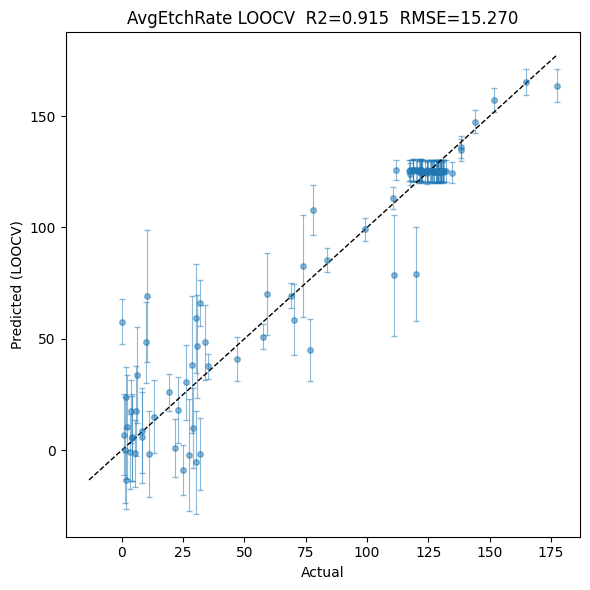

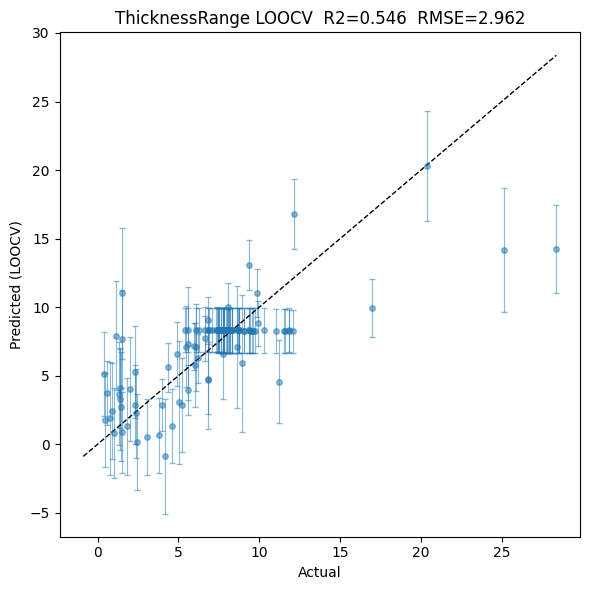

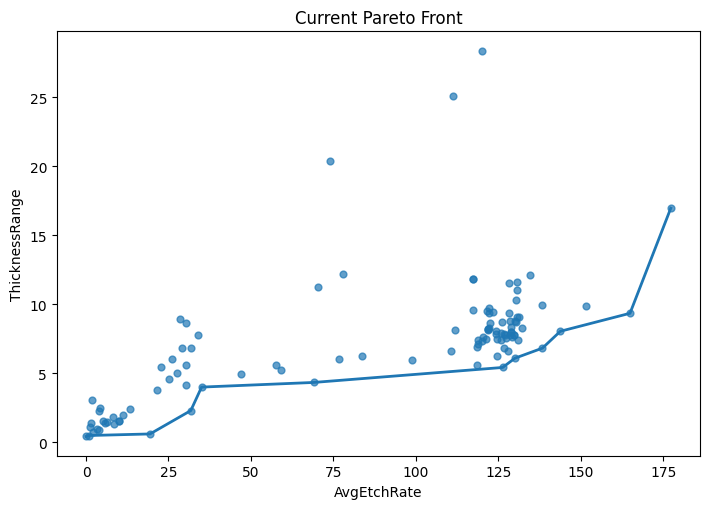

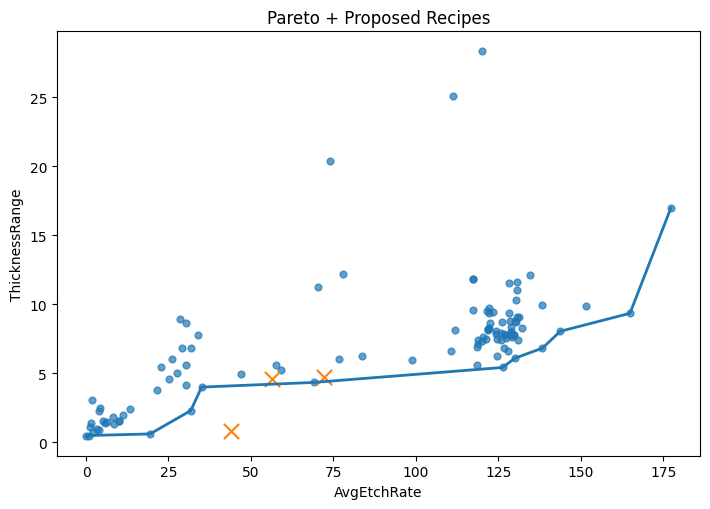


Proposed recipes:
 Etch_Avgcf4Flow  Etch_AvgO2Flow  Etch_Avg_Rf2_Pow  Etch_Avg_Rf1_Pow  Etch_AvgPres  Pred_AvgEtchRate  Unc_AvgEtchRate  Pred_ThicknessRange  Unc_ThicknessRange
            23.7            87.5             697.0              15.0          70.9         72.241510        35.487721             4.696383            5.572037
            54.5            83.7             641.0               6.0          96.0         43.913847        32.428604             0.784786            5.218060
            17.1            70.3             112.0              96.0          17.4         56.318789        28.685611             4.549623            4.837063

Saved: proposed_recipes.csv

AvgEtchRate LOOCV: R2=0.9149 RMSE=15.2703
ThicknessRange LOOCV: R2=0.5464 RMSE=2.9616


In [3]:
#!/usr/bin/env python3
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, List, Optional

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.base import clone
from scipy.stats import qmc

CSV_PATH = "full_dataset.csv"
SEED = 42
NS_OBOL = 8192
N_EI_SAMPLES = 256
N_PROPOSALS = 3

X_FEATURES = [
    "Etch_AvgO2Flow",
    "Etch_Avg_Rf1_Pow",
    "Etch_Avg_Rf2_Pow",
    "Etch_AvgPres",
    "Etch_Avgcf4Flow",
]

Y1_COL = "AvgEtchRate"
Y2_COL = "RangeEtchRate"

THICKNESS_MULT = 5.0
RATE_MIN = 35.0
RATE_MAX = 110.0

BOUNDS_LB = np.array([10.0, 0.0, 50.0, 4.0, 10.0])
BOUNDS_UB = np.array([90.0, 100.0, 700.0, 100.0, 90.0])
RES = np.array([0.1, 1.0, 1.0, 0.1, 0.1])

rng = np.random.default_rng(SEED)

def RMSE(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

def load_data(path):
    df = pd.read_csv(path)
    need = X_FEATURES + [Y1_COL, Y2_COL]
    for c in need:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=need).copy()
    df["ThicknessRange"] = df[Y2_COL] * THICKNESS_MULT
    X = df[X_FEATURES].to_numpy(float)
    y1 = df[Y1_COL].to_numpy(float)
    y2 = df["ThicknessRange"].to_numpy(float)
    return df, X, y1, y2

def make_pipeline():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=C(1.0)*RBF(1.0) + WhiteKernel(1e-3),
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=5,
            random_state=SEED
        ))
    ])
    kernels = []
    for c in (0.1, 1.0, 10.0):
        for l in (0.1, 1.0, 10.0):
            for w in (1e-5, 1e-3, 1e-1):
                kernels.append(C(c)*RBF(l) + WhiteKernel(w))
    grid = {"gpr__kernel": kernels}
    return pipe, grid

def tune_model(X, y):
    pipe, grid = make_pipeline()
    cv = KFold(n_splits=min(3, max(2, len(y))), shuffle=True, random_state=SEED)
    rs = RandomizedSearchCV(
        pipe, param_distributions=grid,
        n_iter=min(25, len(grid["gpr__kernel"])),
        scoring="neg_root_mean_squared_error",
        cv=cv, n_jobs=-1, random_state=SEED, refit=True, verbose=0
    )
    rs.fit(X, y)
    return rs.best_estimator_

def clone_best_kernel(best_estimator):
    g = best_estimator.named_steps["gpr"]
    kernel = g.kernel_ if hasattr(g, "kernel_") else g.kernel
    new = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=0,
            random_state=SEED
        ))
    ])
    return new

def loocv_predict(pipe, X, y):
    loo = LeaveOneOut()
    y_pred = np.zeros_like(y, dtype=float)
    y_std  = np.zeros_like(y, dtype=float)
    for tr, te in loo.split(X):
        m = clone(pipe)
        m.fit(X[tr], y[tr])
        Xt = m.named_steps["scaler"].transform(X[te])
        mu, sd = m.named_steps["gpr"].predict(Xt, return_std=True)
        y_pred[te] = mu
        y_std[te]  = sd
    r2 = r2_score(y, y_pred)
    rmse = RMSE(y, y_pred)
    return y_pred, y_std, r2, rmse

def parity_plot(y, yhat, ysd, title, fname=None):
    plt.figure(figsize=(6,6))
    plt.errorbar(y, yhat, yerr=ysd, fmt='o', ms=4, elinewidth=0.8, capsize=2, alpha=0.5)
    lo = min(float(np.min(y)), float(np.min(yhat)))
    hi = max(float(np.max(y)), float(np.max(yhat)))
    plt.plot([lo,hi],[lo,hi],'k--',lw=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted (LOOCV)")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

def pareto_front_xy(x, y):
    idx = np.argsort(-x)
    xs, ys = x[idx], y[idx]
    keep = []
    best = np.inf
    for i in range(len(xs)):
        if ys[i] <= best + 1e-12:
            keep.append(idx[i])
            best = min(best, ys[i])
    return np.array(keep, dtype=int)

def round_to_res(X, res):
    Z = X.copy()
    for j in range(Z.shape[1]):
        Z[:, j] = np.round(Z[:, j] / res[j]) * res[j]
    return Z

def sobol_candidates(n):
    m = int(np.ceil(np.log2(max(2, n))))
    engine = qmc.Sobol(d=5, scramble=True, seed=SEED)
    U = engine.random_base2(m)
    Xc = BOUNDS_LB + U * (BOUNDS_UB - BOUNDS_LB)
    Xc = round_to_res(Xc, RES)
    Xc = np.unique(Xc, axis=0)
    return Xc

def predict_mu_sd(pipe, Xq):
    Xt = pipe.named_steps["scaler"].transform(Xq)
    mu, sd = pipe.named_steps["gpr"].predict(Xt, return_std=True)
    return mu, sd

def objective_samples(mu_rate, sd_rate, mu_thk, sd_thk, ns=256):
    z1 = rng.normal(mu_rate, sd_rate, size=ns)
    z1 = np.clip(z1, RATE_MIN, RATE_MAX)
    z2 = rng.normal(mu_thk, sd_thk, size=ns)
    return -np.sqrt(((RATE_MAX - z1)/(RATE_MAX - RATE_MIN + 1e-9))**2 + ((z2 - z2.min())/(max(1e-9, z2.max() - z2.min())))**2)

def expected_improvement(mu_r, sd_r, mu_t, sd_t, best, ns=256):
    out = np.empty_like(mu_r)
    zmin = np.minimum.reduce([mu_t - 3*sd_t, np.full_like(mu_t, np.nanmin(mu_t))])
    zmax = np.maximum.reduce([mu_t + 3*sd_t, np.full_like(mu_t, np.nanmax(mu_t))])
    y_min = np.nanmin(zmin)
    y_max = np.nanmax(zmax)
    y_span = max(1e-9, y_max - y_min)
    for i in range(mu_r.shape[0]):
        r = rng.normal(mu_r[i], max(sd_r[i], 1e-9), size=ns)
        r = np.clip(r, RATE_MIN, RATE_MAX)
        t = rng.normal(mu_t[i], max(sd_t[i], 1e-9), size=ns)
        val = -np.sqrt(((RATE_MAX - r)/(RATE_MAX - RATE_MIN + 1e-9))**2 + ((t - y_min)/y_span)**2)
        imp = np.maximum(0.0, val - best)
        out[i] = np.mean(imp)
    return out

def propose_batched_3(pipe_r, pipe_t, X_train, y_rate, y_thk):
    obs_val = -np.sqrt(((RATE_MAX - np.clip(y_rate, RATE_MIN, RATE_MAX))/(RATE_MAX - RATE_MIN + 1e-9))**2 + ((y_thk - y_thk.min())/max(1e-9, y_thk.max() - y_thk.min()))**2)
    best = float(np.max(obs_val))
    Xcand = sobol_candidates(NS_OBOL)
    mu_r, sd_r = predict_mu_sd(pipe_r, Xcand)
    mu_t, sd_t = predict_mu_sd(pipe_t, Xcand)
    ok = (mu_r >= RATE_MIN) & (mu_r <= RATE_MAX)
    Xcand = Xcand[ok]
    mu_r, sd_r, mu_t, sd_t = mu_r[ok], sd_r[ok], mu_t[ok], sd_t[ok]
    props = []
    Xb = X_train.copy()
    yr = y_rate.copy()
    yt = y_thk.copy()
    for k in range(N_PROPOSALS):
        if len(Xcand) == 0: break
        ei = expected_improvement(mu_r, sd_r, mu_t, sd_t, best, ns=N_EI_SAMPLES)
        j = int(np.argmax(ei))
        xp = Xcand[j]
        pr, ur = mu_r[j], sd_r[j]
        pt, ut = mu_t[j], sd_t[j]
        props.append((xp, pr, ur, pt, ut))
        Xb = np.vstack([Xb, xp.reshape(1,-1)])
        yr = np.concatenate([yr, [pr]])
        yt = np.concatenate([yt, [pt]])
        pipe_r = clone_best_kernel(pipe_r); pipe_r.fit(Xb, yr)
        pipe_t = clone_best_kernel(pipe_t); pipe_t.fit(Xb, yt)
        val = -np.sqrt(((RATE_MAX - np.clip(pr, RATE_MIN, RATE_MAX))/(RATE_MAX - RATE_MIN + 1e-9))**2 + ((pt - y_thk.min())/max(1e-9, y_thk.max() - y_thk.min()))**2)
        best = max(best, float(val))
        Xcand = np.delete(Xcand, j, axis=0)
        mu_r, sd_r = predict_mu_sd(pipe_r, Xcand)
        mu_t, sd_t = predict_mu_sd(pipe_t, Xcand)
        ok = (mu_r >= RATE_MIN) & (mu_r <= RATE_MAX)
        Xcand = Xcand[ok]
        mu_r, sd_r, mu_t, sd_t = mu_r[ok], sd_r[ok], mu_t[ok], sd_t[ok]
    return props

def pareto_plot(x, y, title, proposals=None, fname=None):
    idx = pareto_front_xy(x, y)
    px, py = x[idx], y[idx]
    plt.figure(figsize=(7.2,5.2))
    plt.scatter(x, y, s=24, alpha=0.7)
    plt.plot(px, py, lw=2)
    if proposals:
        ux = [p[1] for p in proposals]
        uy = [p[3] for p in proposals]
        plt.scatter(ux, uy, marker='x', s=120)
    plt.xlabel("AvgEtchRate")
    plt.ylabel("ThicknessRange")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

def main():
    df, X, y_rate, y_thk = load_data(CSV_PATH)

    pipe_r = tune_model(X, y_rate)
    pipe_t = tune_model(X, y_thk)

    yhat_r, ysd_r, r2_r, rmse_r = loocv_predict(pipe_r, X, y_rate)
    yhat_t, ysd_t, r2_t, rmse_t = loocv_predict(pipe_t, X, y_thk)

    parity_plot(y_rate, yhat_r, ysd_r, f"AvgEtchRate LOOCV  R2={r2_r:.3f}  RMSE={rmse_r:.3f}")
    parity_plot(y_thk,  yhat_t, ysd_t, f"ThicknessRange LOOCV  R2={r2_t:.3f}  RMSE={rmse_t:.3f}")

    pareto_plot(y_rate, y_thk, "Current Pareto Front")

    pipe_r_fit = clone_best_kernel(pipe_r); pipe_r_fit.fit(X, y_rate)
    pipe_t_fit = clone_best_kernel(pipe_t); pipe_t_fit.fit(X, y_thk)

    proposals = propose_batched_3(pipe_r_fit, pipe_t_fit, X, y_rate, y_thk)

    pareto_plot(y_rate, y_thk, "Pareto + Proposed Recipes", proposals=proposals)

    rows = []
    for p in proposals:
        xp, pr, ur, pt, ut = p
        rows.append({
            "Etch_Avgcf4Flow": xp[4],
            "Etch_AvgO2Flow": xp[0],
            "Etch_Avg_Rf2_Pow": xp[2],
            "Etch_Avg_Rf1_Pow": xp[1],
            "Etch_AvgPres": xp[3],
            "Pred_AvgEtchRate": pr,
            "Unc_AvgEtchRate": ur,
            "Pred_ThicknessRange": pt,
            "Unc_ThicknessRange": ut,
        })
    props_df = pd.DataFrame(rows)
    if not props_df.empty:
        print("\nProposed recipes:")
        print(props_df.to_string(index=False))
        props_df.to_csv("proposed_recipes.csv", index=False)
        print("\nSaved: proposed_recipes.csv")

    print(f"\nAvgEtchRate LOOCV: R2={r2_r:.4f} RMSE={rmse_r:.4f}")
    print(f"ThicknessRange LOOCV: R2={r2_t:.4f} RMSE={rmse_t:.4f}")

if __name__ == "__main__":
    main()


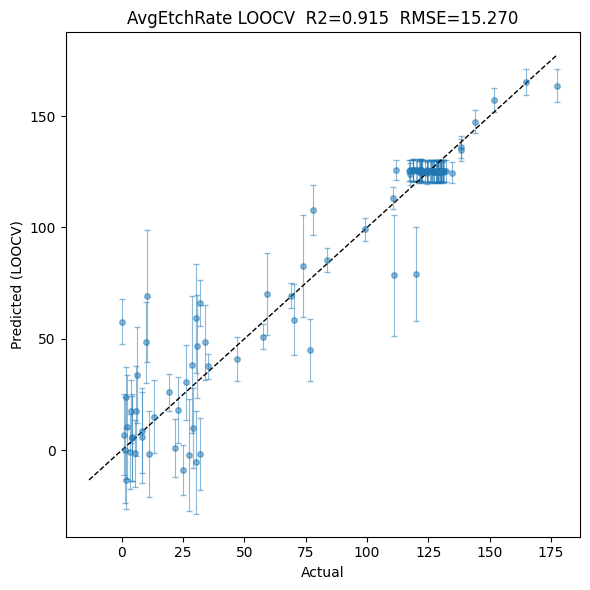

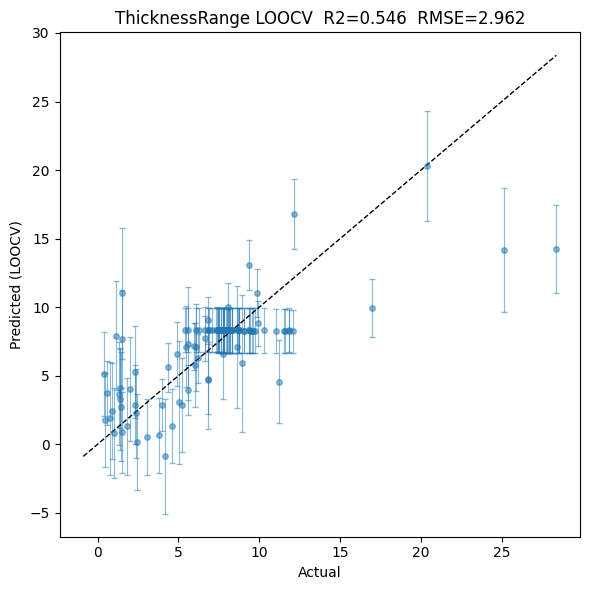

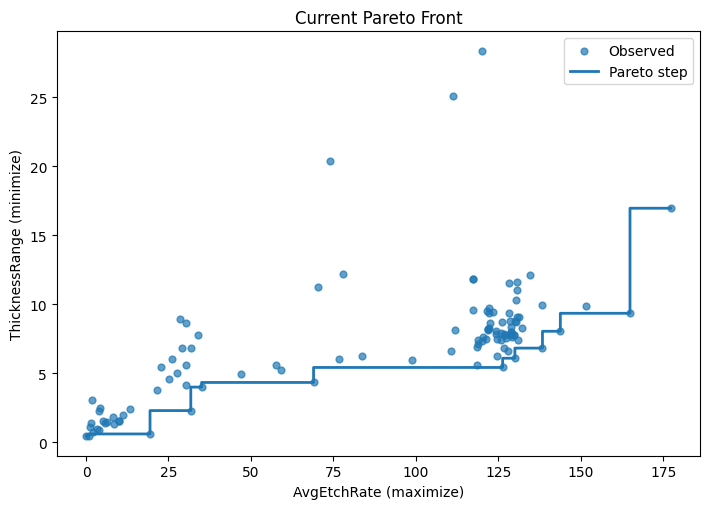

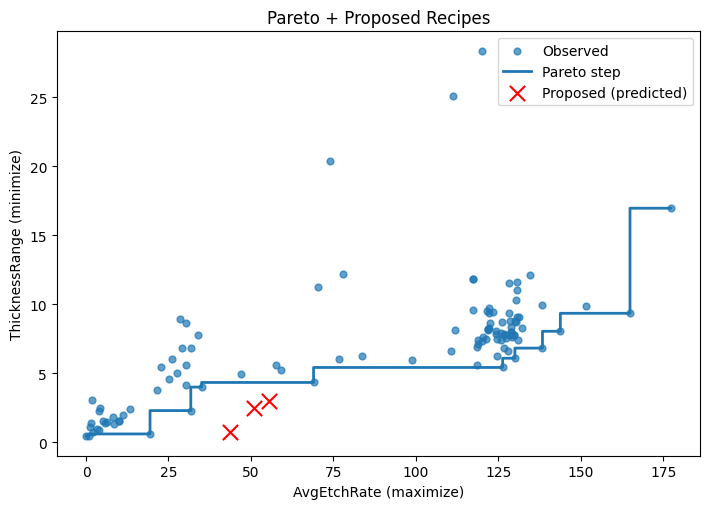


Proposed recipes:
 Etch_Avgcf4Flow  Etch_AvgO2Flow  Etch_Avg_Rf2_Pow  Etch_Avg_Rf1_Pow  Etch_AvgPres  Pred_AvgEtchRate  Unc_AvgEtchRate  Pred_ThicknessRange  Unc_ThicknessRange
            54.5            83.7             641.0               6.0          96.0         43.671967        37.903000             0.773349            5.825978
            12.0            78.3             108.0              79.0           8.1         51.013881        32.379620             2.502330            5.235811
            11.7            18.8              82.0              35.0          10.7         55.532258        28.596886             2.959126            4.772336

Saved: proposed_recipes.csv

AvgEtchRate LOOCV: R2=0.9149 RMSE=15.2703
ThicknessRange LOOCV: R2=0.5464 RMSE=2.9616


In [ ]:
#!/usr/bin/env python3
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, List, Optional

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.base import clone
from scipy.stats import qmc

# =========================
# Config
# =========================
CSV_PATH = "full_dataset.csv"
SEED = 42

NS_OBOL = 8192           # Sobol candidates (before snapping/dedup/filtering)
N_EI_SAMPLES = 256       # MC samples for EI of signed distance
N_PROPOSALS = 3          # batch size
PF_DENSITY = 200         # points per segment to densify Pareto step curve

X_FEATURES = [
    "Etch_AvgO2Flow",
    "Etch_Avg_Rf1_Pow",
    "Etch_Avg_Rf2_Pow",
    "Etch_AvgPres",
    "Etch_Avgcf4Flow",
]

Y1_COL = "AvgEtchRate"      # maximize
Y2_COL = "RangeEtchRate"    # to be multiplied to thickness
THICKNESS_MULT = 5.0        # thickness range = RangeEtchRate * 5

RATE_MIN = 35.0             # allowable/presented rate window
RATE_MAX = 110.0

# Parameter bounds (order matches X_FEATURES)
BOUNDS_LB = np.array([10.0, 0.0, 50.0, 4.0, 10.0])
BOUNDS_UB = np.array([90.0, 100.0, 700.0, 100.0, 90.0])
RES = np.array([0.1, 1.0, 1.0, 0.1, 0.1])

rng = np.random.default_rng(SEED)

def RMSE(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

# =========================
# Data
# =========================
def load_data(path):
    df = pd.read_csv(path)
    need = X_FEATURES + [Y1_COL, Y2_COL]
    for c in need:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=need).copy()
    df["ThicknessRange"] = df[Y2_COL] * THICKNESS_MULT
    X = df[X_FEATURES].to_numpy(float)
    y_rate = df[Y1_COL].to_numpy(float)
    y_thk  = df["ThicknessRange"].to_numpy(float)
    return df, X, y_rate, y_thk

# =========================
# GPR modeling
# =========================
def make_pipeline():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=C(1.0)*RBF(1.0) + WhiteKernel(1e-3),
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=5,
            random_state=SEED
        ))
    ])
    kernels = []
    for c in (0.1, 1.0, 10.0):
        for l in (0.1, 1.0, 10.0):
            for w in (1e-5, 1e-3, 1e-1):
                kernels.append(C(c)*RBF(l) + WhiteKernel(w))
    grid = {"gpr__kernel": kernels}
    return pipe, grid

def tune_model(X, y):
    pipe, grid = make_pipeline()
    cv = KFold(n_splits=min(3, max(2, len(y))), shuffle=True, random_state=SEED)
    rs = RandomizedSearchCV(
        pipe, param_distributions=grid,
        n_iter=min(25, len(grid["gpr__kernel"])),
        scoring="neg_root_mean_squared_error",
        cv=cv, n_jobs=-1, random_state=SEED, refit=True, verbose=0
    )
    rs.fit(X, y)
    return rs.best_estimator_

def clone_best_kernel(best_estimator):
    g = best_estimator.named_steps["gpr"]
    kernel = g.kernel_ if hasattr(g, "kernel_") else g.kernel
    new = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=0,
            random_state=SEED
        ))
    ])
    return new

def loocv_predict(pipe, X, y):
    loo = LeaveOneOut()
    y_pred = np.zeros_like(y, dtype=float)
    y_std  = np.zeros_like(y, dtype=float)
    for tr, te in loo.split(X):
        m = clone(pipe)
        m.fit(X[tr], y[tr])
        Xt = m.named_steps["scaler"].transform(X[te])
        mu, sd = m.named_steps["gpr"].predict(Xt, return_std=True)
        y_pred[te] = mu
        y_std[te]  = sd
    r2 = r2_score(y, y_pred)
    rmse = RMSE(y, y_pred)
    return y_pred, y_std, r2, rmse

def predict_mu_sd(pipe, Xq):
    Xt = pipe.named_steps["scaler"].transform(Xq)
    mu, sd = pipe.named_steps["gpr"].predict(Xt, return_std=True)
    return mu, sd

# =========================
# Pareto front helpers (max rate, min thickness)
# =========================
def pareto_front_indices_maxmin(x, y):
    """Return indices of nondominated points for objectives: maximize x, minimize y."""
    idx = np.argsort(-x)   # sort by decreasing x
    xs, ys = x[idx], y[idx]
    keep = []
    best_y = np.inf
    for i in range(len(xs)):
        if ys[i] <= best_y + 1e-12:
            keep.append(idx[i])
            best_y = min(best_y, ys[i])
    return np.array(keep, dtype=int)

def build_pareto_step_dense(px, py, density=200):
    """
    Given Pareto points sorted by decreasing px, build a step-wise front (max x, min y)
    and densify to 'density' points per segment (vertical + horizontal segments).
    """
    if len(px) <= 1:
        return np.column_stack([px, py])
    # Ensure sort by decreasing px
    order = np.argsort(-px)
    px = px[order]; py = py[order]
    segs = []
    for i in range(len(px)):
        if i > 0:
            # vertical segment at x = px[i], from py[i-1] down to py[i]
            yv = np.linspace(py[i-1], py[i], density)
            xv = np.full_like(yv, px[i])
            segs.append(np.column_stack([xv, yv]))
        if i < len(px)-1:
            # horizontal segment at y = py[i], from x = px[i] to px[i+1]
            xh = np.linspace(px[i], px[i+1], density)
            yh = np.full_like(xh, py[i])
            segs.append(np.column_stack([xh, yh]))
    return np.vstack(segs)

def is_dominated_by_pf(r, t, pf_points):
    """
    Dominated test for objectives (max r, min t).
    Returns True if there exists (r', t') on the PF with r' >= r and t' <= t,
    with at least one strict inequality.
    """
    rp = pf_points[:, 0]; tp = pf_points[:, 1]
    ge_r = rp >= r - 1e-12
    le_t = tp <= t + 1e-12
    mask = ge_r & le_t
    if not np.any(mask):
        return False
    # check any strict dominance
    strict = (rp[mask] > r + 1e-12) | (tp[mask] < t - 1e-12)
    return bool(np.any(strict))

def signed_distance_to_pf(r, t, pf_points, norm=None):
    """
    Signed Euclidean distance from (r,t) to densified PF.
    Positive if non-dominated (improves front), negative if dominated.
    Optionally 'norm' = (rx_scale, ty_scale) to compute distance in normalized space.
    """
    P = pf_points
    if norm is None:
        # raw Euclidean
        d = np.sqrt((P[:,0] - r)**2 + (P[:,1] - t)**2)
    else:
        sx, sy = norm
        d = np.sqrt(((P[:,0] - r)/sx)**2 + ((P[:,1] - t)/sy)**2)
    dmin = float(np.min(d))
    sgn = -1.0 if is_dominated_by_pf(r, t, pf_points) else +1.0
    return sgn * dmin

# =========================
# Candidates
# =========================
def round_to_res(X, res):
    Z = X.copy()
    for j in range(Z.shape[1]):
        Z[:, j] = np.round(Z[:, j] / res[j]) * res[j]
    return Z

def sobol_candidates(n):
    m = int(np.ceil(np.log2(max(2, n))))
    engine = qmc.Sobol(d=len(X_FEATURES), scramble=True, seed=SEED)
    U = engine.random_base2(m)
    Xc = BOUNDS_LB + U * (BOUNDS_UB - BOUNDS_LB)
    Xc = round_to_res(Xc, RES)
    Xc = np.unique(Xc, axis=0)
    return Xc

# =========================
# EI over signed distance to Pareto front
# =========================
def expected_improvement_signed(mu_r, sd_r, mu_t, sd_t, pf_points,
                                s_star=0.0, ns=N_EI_SAMPLES, norm=None):
    """
    Monte Carlo EI on the custom objective s(x) = signed distance to Pareto front.
    For each candidate i:
        Sample (R,T) ~ Normal(mu, sd),
        s^{(s)} = signed_distance_to_pf(R, T, PF),
        EI_i = mean(max(0, s^{(s)} - s_star)).
    """
    n = mu_r.shape[0]
    out = np.zeros(n, dtype=float)
    for i in range(n):
        r = rng.normal(mu_r[i], max(sd_r[i], 1e-12), size=ns)
        t = rng.normal(mu_t[i], max(sd_t[i], 1e-12), size=ns)
        # Optional clamp rate into the presentation window (does not affect sign logic)
        r = np.clip(r, RATE_MIN, RATE_MAX)
        si = np.empty(ns, dtype=float)
        for s in range(ns):
            si[s] = signed_distance_to_pf(r[s], t[s], pf_points, norm=norm)
        out[i] = float(np.mean(np.maximum(0.0, si - s_star)))
    return out

# =========================
# Propose a batch of 3 with fantasy updates
# =========================
def propose_batched_3(pipe_r, pipe_t, X_train, y_rate, y_thk,
                      rate_min=RATE_MIN, rate_max=RATE_MAX,
                      pf_density=PF_DENSITY):
    # Build current PF from observed data
    pf_idx = pareto_front_indices_maxmin(y_rate, y_thk)
    px, py = y_rate[pf_idx], y_thk[pf_idx]
    pf_dense = build_pareto_step_dense(px, py, density=pf_density)

    # Normalization for distance (optional): use observed spans to balance axes
    rx_span = max(1e-9, np.max(y_rate) - np.min(y_rate))
    ty_span = max(1e-9, np.max(y_thk) - np.min(y_thk))
    norm = (rx_span, ty_span)

    # Best-so-far signed distance (PF points have s ~ 0 => s_star = 0 is fine)
    s_star = 0.0

    # Candidates
    Xcand = sobol_candidates(NS_OBOL)
    mu_r, sd_r = predict_mu_sd(pipe_r, Xcand)
    mu_t, sd_t = predict_mu_sd(pipe_t, Xcand)
    ok = (mu_r >= rate_min) & (mu_r <= rate_max)
    Xcand = Xcand[ok]
    mu_r, sd_r, mu_t, sd_t = mu_r[ok], sd_r[ok], mu_t[ok], sd_t[ok]

    proposals = []
    Xb = X_train.copy()
    yr = y_rate.copy()
    yt = y_thk.copy()
    pr_mu, pr_sd, pt_mu, pt_sd = mu_r, sd_r, mu_t, sd_t
    pf_dense_curr = pf_dense.copy()
    norm_curr = norm

    for k in range(N_PROPOSALS):
        if len(Xcand) == 0:
            break
        # EI over signed distance to PF
        ei = expected_improvement_signed(pr_mu, pr_sd, pt_mu, pt_sd,
                                         pf_points=pf_dense_curr,
                                         s_star=s_star, ns=N_EI_SAMPLES,
                                         norm=norm_curr)
        j = int(np.argmax(ei))
        xp = Xcand[j]
        pr, ur = pr_mu[j], pr_sd[j]
        pt, ut = pt_mu[j], pt_sd[j]
        proposals.append((xp, pr, ur, pt, ut))

        # Fantasy update: add predicted point, rebuild PF and refit models
        Xb = np.vstack([Xb, xp.reshape(1, -1)])
        yr = np.concatenate([yr, [pr]])
        yt = np.concatenate([yt, [pt]])

        pipe_r = clone_best_kernel(pipe_r); pipe_r.fit(Xb, yr)
        pipe_t = clone_best_kernel(pipe_t); pipe_t.fit(Xb, yt)

        # Update PF with fantasy point and recompute normalization
        pf_idx_new = pareto_front_indices_maxmin(yr, yt)
        px_new, py_new = yr[pf_idx_new], yt[pf_idx_new]
        pf_dense_curr = build_pareto_step_dense(px_new, py_new, density=pf_density)
        rx_span = max(1e-9, np.max(yr) - np.min(yr))
        ty_span = max(1e-9, np.max(yt) - np.min(yt))
        norm_curr = (rx_span, ty_span)

        # s_star remains 0 (front points define 0 distance); keeping 0 encourages true front expansion

        # Remove chosen and refresh candidate predictions under updated models
        Xcand = np.delete(Xcand, j, axis=0)
        if len(Xcand) == 0:
            break
        pr_mu, pr_sd = predict_mu_sd(pipe_r, Xcand)
        pt_mu, pt_sd = predict_mu_sd(pipe_t, Xcand)
        ok = (pr_mu >= rate_min) & (pr_mu <= rate_max)
        Xcand = Xcand[ok]
        pr_mu, pr_sd, pt_mu, pt_sd = pr_mu[ok], pr_sd[ok], pt_mu[ok], pt_sd[ok]

    return proposals

# =========================
# Plotting
# =========================
def parity_plot(y, yhat, ysd, title, fname=None):
    plt.figure(figsize=(6,6))
    plt.errorbar(y, yhat, yerr=ysd, fmt='o', ms=4, elinewidth=0.8, capsize=2, alpha=0.5)
    lo = min(float(np.min(y)), float(np.min(yhat)))
    hi = max(float(np.max(y)), float(np.max(yhat)))
    plt.plot([lo,hi],[lo,hi],'k--',lw=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted (LOOCV)")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

def pareto_plot(x, y, title, proposals=None, fname=None):
    idx = pareto_front_indices_maxmin(x, y)
    px, py = x[idx], y[idx]
    # Build step for display
    pf_dense = build_pareto_step_dense(px, py, density=200)

    plt.figure(figsize=(7.2,5.2))
    plt.scatter(x, y, s=24, alpha=0.7, label="Observed")
    if len(pf_dense) > 1:
        plt.plot(pf_dense[:,0], pf_dense[:,1], lw=2, label="Pareto step")
    else:
        plt.scatter(px, py, c="C1", s=40, label="Pareto point")
    if proposals:
        ux = [p[1] for p in proposals]
        uy = [p[3] for p in proposals]
        plt.scatter(ux, uy, marker='x', s=120, c='red', label="Proposed (predicted)")
    plt.xlabel("AvgEtchRate (maximize)")
    plt.ylabel("ThicknessRange (minimize)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

# =========================
# Main
# =========================
def main():
    df, X, y_rate, y_thk = load_data(CSV_PATH)

    # Train models with kernel tuning
    pipe_r = tune_model(X, y_rate)
    pipe_t = tune_model(X, y_thk)

    # LOOCV diagnostics
    yhat_r, ysd_r, r2_r, rmse_r = loocv_predict(pipe_r, X, y_rate)
    yhat_t, ysd_t, r2_t, rmse_t = loocv_predict(pipe_t, X, y_thk)

    parity_plot(y_rate, yhat_r, ysd_r, f"AvgEtchRate LOOCV  R2={r2_r:.3f}  RMSE={rmse_r:.3f}")
    parity_plot(y_thk,  yhat_t, ysd_t, f"ThicknessRange LOOCV  R2={r2_t:.3f}  RMSE={rmse_t:.3f}")

    pareto_plot(y_rate, y_thk, "Current Pareto Front")

    # Refit on all data (no restarts) for fast acquisition loops
    pipe_r_fit = clone_best_kernel(pipe_r); pipe_r_fit.fit(X, y_rate)
    pipe_t_fit = clone_best_kernel(pipe_t); pipe_t_fit.fit(X, y_thk)

    # Propose 3 via EI on signed distance to PF with fantasy updates
    proposals = propose_batched_3(pipe_r_fit, pipe_t_fit, X, y_rate, y_thk,
                                  rate_min=RATE_MIN, rate_max=RATE_MAX,
                                  pf_density=PF_DENSITY)

    pareto_plot(y_rate, y_thk, "Pareto + Proposed Recipes", proposals=proposals)

    # Output table
    rows = []
    for p in proposals:
        xp, pr, ur, pt, ut = p
        rows.append({
            "Etch_Avgcf4Flow":  xp[4],
            "Etch_AvgO2Flow":   xp[0],
            "Etch_Avg_Rf2_Pow": xp[2],
            "Etch_Avg_Rf1_Pow": xp[1],
            "Etch_AvgPres":     xp[3],
            "Pred_AvgEtchRate": pr,
            "Unc_AvgEtchRate":  ur,
            "Pred_ThicknessRange": pt,
            "Unc_ThicknessRange":  ut,
        })
    props_df = pd.DataFrame(rows)
    if not props_df.empty:
        print("\nProposed recipes:")
        print(props_df.to_string(index=False))
        props_df.to_csv("proposed_recipes.csv", index=False)
        print("\nSaved: proposed_recipes.csv")

    print(f"\nAvgEtchRate LOOCV: R2={r2_r:.4f} RMSE={rmse_r:.4f}")
    print(f"ThicknessRange LOOCV: R2={r2_t:.4f} RMSE={rmse_t:.4f}")

if __name__ == "__main__":
    main()


qEI

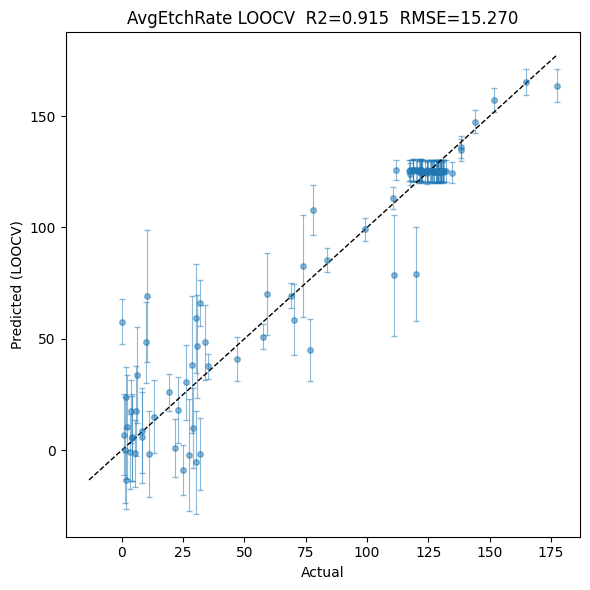

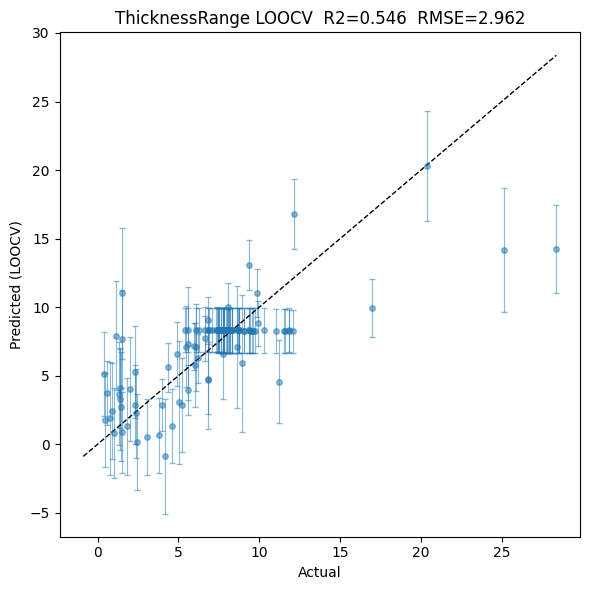

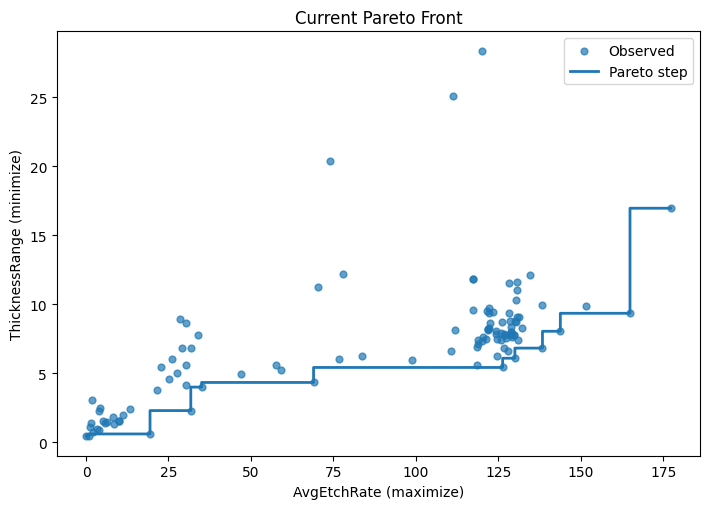

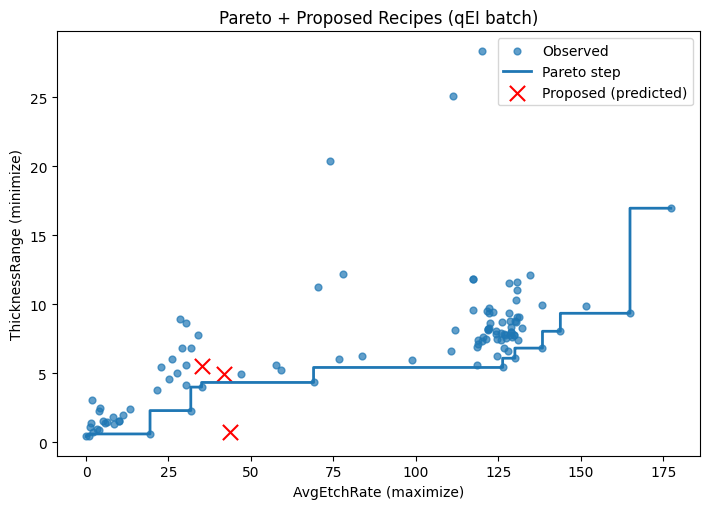


Proposed recipes (qEI batch):
 Etch_Avgcf4Flow  Etch_AvgO2Flow  Etch_Avg_Rf2_Pow  Etch_Avg_Rf1_Pow  Etch_AvgPres  Pred_AvgEtchRate  Unc_AvgEtchRate  Pred_ThicknessRange  Unc_ThicknessRange
            27.7            63.7             689.0              40.0          31.4         41.948219        13.970702             4.958416            3.000369
            54.5            83.7             641.0               6.0          96.0         43.671967        37.903000             0.773349            5.825978
            29.4            49.4             643.0              64.0          96.8         35.208738        27.699971             5.552048            4.634109

Saved: proposed_recipes_qei.csv

AvgEtchRate LOOCV: R2=0.9149 RMSE=15.2703
ThicknessRange LOOCV: R2=0.5464 RMSE=2.9616


In [8]:
#!/usr/bin/env python3
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.base import clone
from scipy.stats import qmc

# =========================
# Config
# =========================
CSV_PATH = "full_dataset.csv"
SEED = 42

NS_OBOL = 8192           # Sobol candidates (before snapping/dedup/filtering)
N_MC = 256               # MC samples for qEI
BATCH_Q = 3              # joint batch size
N_BATCH_EVALS = 2000     # how many random 3-tuples to evaluate for qEI
PF_DENSITY = 200         # points/segment to densify Pareto step curve

X_FEATURES = [
    "Etch_AvgO2Flow",
    "Etch_Avg_Rf1_Pow",
    "Etch_Avg_Rf2_Pow",
    "Etch_AvgPres",
    "Etch_Avgcf4Flow",
]

Y1_COL = "AvgEtchRate"      # maximize
Y2_COL = "RangeEtchRate"    # * 5 to get thickness range
THICKNESS_MULT = 5.0

# presentation/rule window for rate
RATE_MIN = 35.0
RATE_MAX = 110.0

# parameter bounds (order matches X_FEATURES)
BOUNDS_LB = np.array([10.0, 0.0, 50.0, 4.0, 10.0])
BOUNDS_UB = np.array([90.0, 100.0, 700.0, 100.0, 90.0])
RES = np.array([0.1, 1.0, 1.0, 0.1, 0.1])

rng = np.random.default_rng(SEED)

def RMSE(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

# =========================
# Data
# =========================
def load_data(path):
    df = pd.read_csv(path)
    need = X_FEATURES + [Y1_COL, Y2_COL]
    for c in need:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=need).copy()
    df["ThicknessRange"] = df[Y2_COL] * THICKNESS_MULT
    X = df[X_FEATURES].to_numpy(float)
    y_rate = df[Y1_COL].to_numpy(float)
    y_thk  = df["ThicknessRange"].to_numpy(float)
    return df, X, y_rate, y_thk

# =========================
# GPR modeling
# =========================
def make_pipeline():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=C(1.0)*RBF(1.0) + WhiteKernel(1e-3),
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=5,
            random_state=SEED
        ))
    ])
    kernels = []
    for c in (0.1, 1.0, 10.0):
        for l in (0.1, 1.0, 10.0):
            for w in (1e-5, 1e-3, 1e-1):
                kernels.append(C(c)*RBF(l) + WhiteKernel(w))
    grid = {"gpr__kernel": kernels}
    return pipe, grid

def tune_model(X, y):
    pipe, grid = make_pipeline()
    cv = KFold(n_splits=min(3, max(2, len(y))), shuffle=True, random_state=SEED)
    rs = RandomizedSearchCV(
        pipe, param_distributions=grid,
        n_iter=min(25, len(grid["gpr__kernel"])),
        scoring="neg_root_mean_squared_error",
        cv=cv, n_jobs=-1, random_state=SEED, refit=True, verbose=0
    )
    rs.fit(X, y)
    return rs.best_estimator_

def clone_best_kernel(best_estimator):
    g = best_estimator.named_steps["gpr"]
    kernel = g.kernel_ if hasattr(g, "kernel_") else g.kernel
    new = Pipeline([
        ("scaler", StandardScaler()),
        ("gpr", GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            alpha=1e-10,
            n_restarts_optimizer=0,
            random_state=SEED
        ))
    ])
    return new

def loocv_predict(pipe, X, y):
    loo = LeaveOneOut()
    y_pred = np.zeros_like(y, dtype=float)
    y_std  = np.zeros_like(y, dtype=float)
    for tr, te in loo.split(X):
        m = clone(pipe)
        m.fit(X[tr], y[tr])
        Xt = m.named_steps["scaler"].transform(X[te])
        mu, sd = m.named_steps["gpr"].predict(Xt, return_std=True)
        y_pred[te] = mu
        y_std[te]  = sd
    r2 = r2_score(y, y_pred)
    rmse = RMSE(y, y_pred)
    return y_pred, y_std, r2, rmse

def gp_predict_joint(pipe, Xq):
    """Return joint mean vector and covariance matrix for a set of query points Xq."""
    Xt = pipe.named_steps["scaler"].transform(Xq)
    gpr = pipe.named_steps["gpr"]
    mu, cov = gpr.predict(Xt, return_cov=True)
    return mu, cov

# =========================
# Pareto front helpers (max rate, min thickness)
# =========================
def pareto_front_indices_maxmin(x, y):
    """Return indices of nondominated points for objectives: maximize x, minimize y."""
    idx = np.argsort(-x)   # sort by decreasing x
    xs, ys = x[idx], y[idx]
    keep = []
    best_y = np.inf
    for i in range(len(xs)):
        if ys[i] <= best_y + 1e-12:
            keep.append(idx[i])
            best_y = min(best_y, ys[i])
    return np.array(keep, dtype=int)

def build_pareto_step_dense(px, py, density=200):
    """Step-wise PF (max x, min y) densified to many points."""
    if len(px) <= 1:
        return np.column_stack([px, py])
    order = np.argsort(-px)
    px = px[order]; py = py[order]
    segs = []
    for i in range(len(px)):
        if i > 0:
            yv = np.linspace(py[i-1], py[i], density)
            xv = np.full_like(yv, px[i])
            segs.append(np.column_stack([xv, yv]))
        if i < len(px)-1:
            xh = np.linspace(px[i], px[i+1], density)
            yh = np.full_like(xh, py[i])
            segs.append(np.column_stack([xh, yh]))
    return np.vstack(segs)

def is_dominated_by_pf(r, t, pf_points):
    """Dominated test for objectives (max r, min t)."""
    rp = pf_points[:, 0]; tp = pf_points[:, 1]
    ge_r = rp >= r - 1e-12
    le_t = tp <= t + 1e-12
    mask = ge_r & le_t
    if not np.any(mask):
        return False
    strict = (rp[mask] > r + 1e-12) | (tp[mask] < t - 1e-12)
    return bool(np.any(strict))

def signed_distance_to_pf(r, t, pf_points, norm=None):
    """Signed Euclidean distance to PF: positive if non-dominated, negative if dominated."""
    P = pf_points
    if norm is None:
        d = np.sqrt((P[:,0] - r)**2 + (P[:,1] - t)**2)
    else:
        sx, sy = norm
        d = np.sqrt(((P[:,0] - r)/sx)**2 + ((P[:,1] - t)/sy)**2)
    dmin = float(np.min(d))
    sgn = -1.0 if is_dominated_by_pf(r, t, pf_points) else +1.0
    return sgn * dmin

# =========================
# Candidates
# =========================
def round_to_res(X, res):
    Z = X.copy()
    for j in range(Z.shape[1]):
        Z[:, j] = np.round(Z[:, j] / res[j]) * res[j]
    return Z

def sobol_candidates(n):
    m = int(np.ceil(np.log2(max(2, n))))
    engine = qmc.Sobol(d=len(X_FEATURES), scramble=True, seed=SEED)
    U = engine.random_base2(m)
    Xc = BOUNDS_LB + U * (BOUNDS_UB - BOUNDS_LB)
    Xc = round_to_res(Xc, RES)
    Xc = np.unique(Xc, axis=0)
    return Xc

# =========================
# qEI over signed distance to PF (joint selection of 3)
# =========================
def qei_signed_batch(mu_r, cov_r, mu_t, cov_t, pf_points, s_star=0.0,
                     ns=N_MC, norm=None):
    """
    Joint EI for a batch:
      Draw (R, T) jointly across the batch from MVNs, compute signed distances
      for each point in the batch, take improvement in max over the batch.
    """
    q = mu_r.shape[0]
    # Cholesky (robust)
    jitter = 1e-10
    Lr = np.linalg.cholesky(cov_r + jitter*np.eye(q))
    Lt = np.linalg.cholesky(cov_t + jitter*np.eye(q))

    gain = 0.0
    for s in range(ns):
        zr = rng.standard_normal(q)
        zt = rng.standard_normal(q)
        r = mu_r + Lr @ zr
        t = mu_t + Lt @ zt
        # clamp rate to presentation window (optional)
        r = np.clip(r, RATE_MIN, RATE_MAX)
        # signed distance per point
        s_vals = np.array([signed_distance_to_pf(r[i], t[i], pf_points, norm=norm)
                           for i in range(q)])
        imp = max(0.0, np.max(s_vals) - s_star)
        gain += imp
    return gain / ns

def propose_batch_qei(pipe_r, pipe_t, X_train, y_rate, y_thk,
                      rate_min=RATE_MIN, rate_max=RATE_MAX,
                      pf_density=PF_DENSITY,
                      q=BATCH_Q, n_batches=N_BATCH_EVALS):
    """
    Build candidate pool -> compute joint GP mean/cov for (rate,thk) ->
    sample many random 3-tuples -> evaluate qEI -> return best batch.
    """
    # PF from observed data
    pf_idx = pareto_front_indices_maxmin(y_rate, y_thk)
    px, py = y_rate[pf_idx], y_thk[pf_idx]
    pf_dense = build_pareto_step_dense(px, py, density=pf_density)

    # distance normalization for balance
    rx_span = max(1e-9, np.max(y_rate) - np.min(y_rate))
    ty_span = max(1e-9, np.max(y_thk) - np.min(y_thk))
    norm = (rx_span, ty_span)

    s_star = 0.0  # PF points define zero distance

    # Candidate pool
    Xcand = sobol_candidates(NS_OBOL)
    # Predict means & covariances jointly for the whole pool
    mu_r_all, cov_r_all = gp_predict_joint(pipe_r, Xcand)
    mu_t_all, cov_t_all = gp_predict_joint(pipe_t, Xcand)

    # Keep candidates whose mean rate is in window
    ok = (mu_r_all >= rate_min) & (mu_r_all <= rate_max)
    Xcand = Xcand[ok]
    mu_r_all, mu_t_all = mu_r_all[ok], mu_t_all[ok]
    cov_r_all = cov_r_all[np.ix_(ok, ok)]
    cov_t_all = cov_t_all[np.ix_(ok, ok)]

    n = len(Xcand)
    if n < q:
        return []

    best_ei = -np.inf
    best_idx = None

    # randomized search over batch 3-tuples
    for _ in range(n_batches):
        idx = rng.choice(n, size=q, replace=False)
        # slice joint stats for the batch
        mu_r = mu_r_all[idx]
        mu_t = mu_t_all[idx]
        cov_r = cov_r_all[np.ix_(idx, idx)]
        cov_t = cov_t_all[np.ix_(idx, idx)]
        # qEI
        ei = qei_signed_batch(mu_r, cov_r, mu_t, cov_t, pf_points=pf_dense,
                              s_star=s_star, ns=N_MC, norm=norm)
        if ei > best_ei:
            best_ei = ei
            best_idx = idx

    # return the chosen batch with predicted means/stds (diag of cov)
    idx = best_idx
    proposals = []
    for i in idx:
        pr = mu_r_all[i]; pt = mu_t_all[i]
        ur = np.sqrt(max(0.0, cov_r_all[i, i]))
        ut = np.sqrt(max(0.0, cov_t_all[i, i]))
        proposals.append((Xcand[i], pr, ur, pt, ut))
    return proposals

# =========================
# Plotting
# =========================
def parity_plot(y, yhat, ysd, title, fname=None):
    plt.figure(figsize=(6,6))
    plt.errorbar(y, yhat, yerr=ysd, fmt='o', ms=4, elinewidth=0.8, capsize=2, alpha=0.5)
    lo = min(float(np.min(y)), float(np.min(yhat)))
    hi = max(float(np.max(y)), float(np.max(yhat)))
    plt.plot([lo,hi],[lo,hi],'k--',lw=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted (LOOCV)")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

def pareto_plot(x, y, title, proposals=None, fname=None):
    idx = pareto_front_indices_maxmin(x, y)
    px, py = x[idx], y[idx]
    pf_dense = build_pareto_step_dense(px, py, density=200)

    plt.figure(figsize=(7.2,5.2))
    plt.scatter(x, y, s=24, alpha=0.7, label="Observed")
    if len(pf_dense) > 1:
        plt.plot(pf_dense[:,0], pf_dense[:,1], lw=2, label="Pareto step")
    else:
        plt.scatter(px, py, c="C1", s=40, label="Pareto point")
    if proposals:
        ux = [p[1] for p in proposals]
        uy = [p[3] for p in proposals]
        plt.scatter(ux, uy, marker='x', s=120, c='red', label="Proposed (predicted)")
    plt.xlabel("AvgEtchRate (maximize)")
    plt.ylabel("ThicknessRange (minimize)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

# =========================
# Main
# =========================
def main():
    df, X, y_rate, y_thk = load_data(CSV_PATH)

    # Train models with kernel tuning
    pipe_r = tune_model(X, y_rate)
    pipe_t = tune_model(X, y_thk)

    # LOOCV diagnostics
    yhat_r, ysd_r, r2_r, rmse_r = loocv_predict(pipe_r, X, y_rate)
    yhat_t, ysd_t, r2_t, rmse_t = loocv_predict(pipe_t, X, y_thk)

    parity_plot(y_rate, yhat_r, ysd_r, f"AvgEtchRate LOOCV  R2={r2_r:.3f}  RMSE={rmse_r:.3f}")
    parity_plot(y_thk,  yhat_t, ysd_t, f"ThicknessRange LOOCV  R2={r2_t:.3f}  RMSE={rmse_t:.3f}")

    pareto_plot(y_rate, y_thk, "Current Pareto Front")

    # Refit on all data (no restarts) for acquisition
    pipe_r_fit = clone_best_kernel(pipe_r); pipe_r_fit.fit(X, y_rate)
    pipe_t_fit = clone_best_kernel(pipe_t); pipe_t_fit.fit(X, y_thk)

    # === qEI batch proposal (size=3) ===
    proposals = propose_batch_qei(pipe_r_fit, pipe_t_fit, X, y_rate, y_thk,
                                  rate_min=RATE_MIN, rate_max=RATE_MAX,
                                  pf_density=PF_DENSITY,
                                  q=BATCH_Q, n_batches=N_BATCH_EVALS)

    pareto_plot(y_rate, y_thk, "Pareto + Proposed Recipes (qEI batch)", proposals=proposals)

    rows = []
    for p in proposals:
        xp, pr, ur, pt, ut = p
        rows.append({
            "Etch_Avgcf4Flow":  xp[4],
            "Etch_AvgO2Flow":   xp[0],
            "Etch_Avg_Rf2_Pow": xp[2],
            "Etch_Avg_Rf1_Pow": xp[1],
            "Etch_AvgPres":     xp[3],
            "Pred_AvgEtchRate": pr,
            "Unc_AvgEtchRate":  ur,
            "Pred_ThicknessRange": pt,
            "Unc_ThicknessRange":  ut,
        })
    props_df = pd.DataFrame(rows)
    if not props_df.empty:
        print("\nProposed recipes (qEI batch):")
        print(props_df.to_string(index=False))
        props_df.to_csv("proposed_recipes_qei.csv", index=False)
        print("\nSaved: proposed_recipes_qei.csv")

    print(f"\nAvgEtchRate LOOCV: R2={r2_r:.4f} RMSE={rmse_r:.4f}")
    print(f"ThicknessRange LOOCV: R2={r2_t:.4f} RMSE={rmse_t:.4f}")

if __name__ == "__main__":
    main()
